In [18]:
import json
 
f = open('5may2022-graph.json') # LND `describegraph` output taken on May 5, 2022
data = json.load(f)
f.close()

print("# nodes = " + str(len(data['nodes'])))
print("# edges = " + str(len(data['edges'])))
 
PK = [x['pub_key'] for x in data['nodes']]
PKtoV = {}
for i in range(len(PK)):
    PKtoV[PK[i]] = i;

n = len(data['nodes'])
E = {};
E_w = {};
for v in range(n):
    E[v] = [];
    E_w[v] = [];
for e in data['edges']:
    u = PKtoV[e['node1_pub']]
    v = PKtoV[e['node2_pub']]
    C = int(e['capacity'])
    E[u].append([v, 1]) # unweighted graph
    E[v].append([u, 1])
    E_w[u].append([v, C]) # weighted graph
    E_w[v].append([u, C])


# nodes = 17813
# edges = 84927


In [19]:
# greedy algorithm #1
# returns list partition, s.t. partition[v] = 0/1 depending on the side of v in the partition
def COMPUTE_IMBALANCED_MAX_CUT(n, E, k):
    if (n<k):
        return [];
    partition = [0] * n # initially all nodes are on the 0 side
    cut_capacity = [0]
    edges_count = [0]
    for i in range(k):
        print("greedy step " + str(i+1) + "/" + str(k))
        best_vertex = -1;
        best_increase = 0;
        for j in range(n):
            if (partition[j] == 0): # consider only nodes still on the 0 side
                C_cut = 0; # compute total capacity incident to node j in the cut
                C_notcut = 0; # compute total capacity incident to node j NOT in the cut
                a = 0
                b = 0
                for e in E[j]:
                    if (partition[e[0]] == 0):
                        C_notcut += e[1];
                        b += 1
                    else:
                        C_cut += e[1];
                        a += 1
                        
                new_increase = C_notcut - C_cut;
                if ((best_vertex < 0) or (new_increase > best_increase)):
                    tmp = b - a
                    best_vertex = j;
                    best_increase = new_increase;
        partition[best_vertex] = 1; # make best greedy move
        cut_capacity.append(cut_capacity[-1] + best_increase)
        edges_count.append(edges_count[-1] + tmp)
    return partition

# returns the capacities of all greedy max cuts for all values of k
# i.e. cut_capacity[i] is the capacity of the greedy max cut with i nodes on one side
# note that cut_capacity[i] for all i>n/2 is ommitted since capacity[i] <= capacity[n-i] in this case
def COMPUTE_ALL_GREEDY_IMBALANCED_MAX_CUTS(n, E, ):#weighted):
    cut_capacity = [0]

    edges_count = [0]
    edges_capacity = [0]
    partition = [0] * n # initially all nodes are on the 0 side
    for i in range(int(n/2)): # consider only cuts of up to n/2 nodes on one side
        #if (int(i*100/(n/2))>int((i-1)*100/(n/2))):
            #print("greedy step " + str(i+1) + "/" + str(n/2))
        print("greedy step: " + str(i+1) + "/" + str(int(n/2)))
        best_vertex = -1;
        best_increase = 0;
        for j in range(n):
            if (partition[j] == 0): # consider only nodes still on the 0 side
                C_cut = 0; # compute total capacity incident to node j in the cut
                C_notcut = 0; # compute total capacity incident to node j NOT in the cut
                a = 0
                b = 0
                for e in E[j]:
                    if (partition[e[0]] == 0): # if the other node in this edge (NOT J) is in 0, so e is already covered
                        C_notcut += e[1];
                        b += 1
                    else:
                        C_cut += e[1];
                        a += 1

                new_increase = C_notcut - C_cut; # check if increase must be computed differently (max)
                if ((best_vertex < 0) or (new_increase > best_increase)):
                    tmp = b - a
                    best_vertex = j;
                    best_increase = new_increase;
        partition[best_vertex] = 1; # make best greedy move

        # cut_capacity.append(compute_cut_capacity(partition, weighted))

        # edges_count.append(compute_cut_capacity(partition, False))
        
        # edges_capacity.append(compute_cut_capacity(partition, True))
        
        cut_capacity.append(cut_capacity[-1] + best_increase)

        edges_count.append(edges_count[-1] + tmp)
        
        edges_capacity.append(edges_capacity[-1] + get_capacity_increase_of_edges_from_vertex(partition, best_vertex))
        
    return cut_capacity, edges_count, edges_capacity

# Used to compute the increase of capacity in each step of the LMC
def get_capacity_increase_of_edges_from_vertex(partition, best_vertex):
    C_cut = 0 # compute total capacity incident to node j in the cut
    C_notcut = 0 # compute total capacity incident to node j NOT in the cut
    for e in E_w[best_vertex]:
        if (partition[e[0]] == 0):
            C_notcut += e[1]
        else:
            C_cut += e[1]    
    capacity_increase = C_notcut - C_cut
    return capacity_increase
    #return C_notcut

def compute_cut_capacity(partition, weighted): # todo: pass E as param
    edges = E_w if weighted else E
    total = 0
    covered_edges = {}
    for i in range(len(partition)):
        if(partition[i] == 1):
            for e in edges[i]:
                if (partition[e[0]] == 0):
                    if(not (f"{i}{e[0]}" in covered_edges or f"{e[0]}{i}" in covered_edges)):
                        covered_edges[f"{i}{e[0]}"] = True
                        total += e[1]
    return total                

In [20]:
# Code to produce the JSON file to analyze the computed max-cut, not needed for experiments

#import requests
#import time

#P = COMPUTE_IMBALANCED_MAX_CUT(n, E_w, 30)
# nodes_in_weighted_max_cut = []

# for i in range(len(P)):
#     if(P[i] == 1):
#         res = requests.get(f"https://1ml.com/node/{PK[i]}/json")
#         nodes_in_weighted_max_cut.append(res.json())
#         print(f"{len(nodes_in_weighted_max_cut)} done")
#         time.sleep(1)


# with open('nodes-in-weighted-max-cut.json', 'w') as outfile:
#     json.dump(nodes_in_weighted_max_cut, outfile)

# Computing LMC and LWMC
C, edges_count, edges_capacity = COMPUTE_ALL_GREEDY_IMBALANCED_MAX_CUTS(n, E)#, False)
C_w, edges_count_w, edges_capacity_w = COMPUTE_ALL_GREEDY_IMBALANCED_MAX_CUTS(n, E_w)#, True)

greedy step: 1/8906
greedy step: 2/8906
greedy step: 3/8906
greedy step: 4/8906
greedy step: 5/8906
greedy step: 6/8906
greedy step: 7/8906
greedy step: 8/8906
greedy step: 9/8906
greedy step: 10/8906
greedy step: 11/8906
greedy step: 12/8906
greedy step: 13/8906
greedy step: 14/8906
greedy step: 15/8906
greedy step: 16/8906
greedy step: 17/8906
greedy step: 18/8906
greedy step: 19/8906
greedy step: 20/8906
greedy step: 21/8906
greedy step: 22/8906
greedy step: 23/8906
greedy step: 24/8906
greedy step: 25/8906
greedy step: 26/8906
greedy step: 27/8906
greedy step: 28/8906
greedy step: 29/8906
greedy step: 30/8906
greedy step: 31/8906
greedy step: 32/8906
greedy step: 33/8906
greedy step: 34/8906
greedy step: 35/8906
greedy step: 36/8906
greedy step: 37/8906
greedy step: 38/8906
greedy step: 39/8906
greedy step: 40/8906
greedy step: 41/8906
greedy step: 42/8906
greedy step: 43/8906
greedy step: 44/8906
greedy step: 45/8906
greedy step: 46/8906
greedy step: 47/8906
greedy step: 48/8906
g

LWMC:

k = 10
capacity = 119989207382
number of edges = 10911
capacity over OPT capacity = 119989207382 / 258711667453 = 46.38%
number of edges over OPT number of edges = 10911 / 62249 = 17.53%
capacity over MAX LWMC capacity = 119989207382 / 246436727385 = 48.69%
******************************************
k = 20
capacity = 151342104519
number of edges = 17353
capacity over OPT capacity = 151342104519 / 258711667453 = 58.50%
number of edges over OPT number of edges = 17353 / 62249 = 27.88%
capacity over MAX LWMC capacity = 151342104519 / 246436727385 = 61.41%
******************************************
k = 30
capacity = 168512912253
number of edges = 20084
capacity over OPT capacity = 168512912253 / 258711667453 = 65.14%
number of edges over OPT number of edges = 20084 / 62249 = 32.26%
capacity over MAX LWMC capacity = 168512912253 / 246436727385 = 68.38%
******************************************
k = 40
capacity = 179606715202
number of edges = 22731
capacity over OPT capacity = 179606

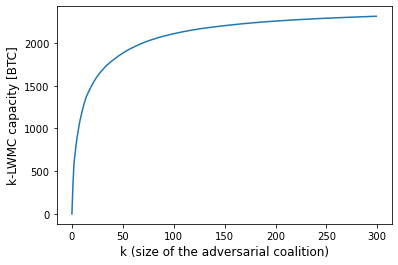

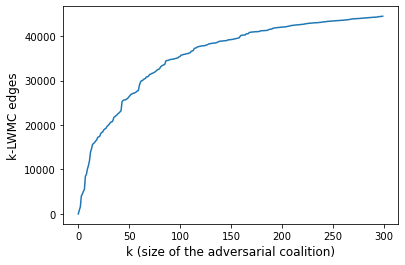

LMC:

k = 10
capacity = 82708398759
number of edges = 15725
capacity over OPT capacity = 82708398759 / 258711667453 = 31.97%
number of edges over OPT number of edges = 15725 / 62249 = 25.26%
number of edges over MAX LMC number of edges = 15725 / 63251 = 24.86%
******************************************
k = 20
capacity = 126345461563
number of edges = 22666
capacity over OPT capacity = 126345461563 / 258711667453 = 48.84%
number of edges over OPT number of edges = 22666 / 62249 = 36.41%
number of edges over MAX LMC number of edges = 22666 / 63251 = 35.84%
******************************************
k = 30
capacity = 151440101350
number of edges = 26729
capacity over OPT capacity = 151440101350 / 258711667453 = 58.54%
number of edges over OPT number of edges = 26729 / 62249 = 42.94%
number of edges over MAX LMC number of edges = 26729 / 63251 = 42.26%
******************************************
k = 40
capacity = 161415845649
number of edges = 29987
capacity over OPT capacity = 161415845649

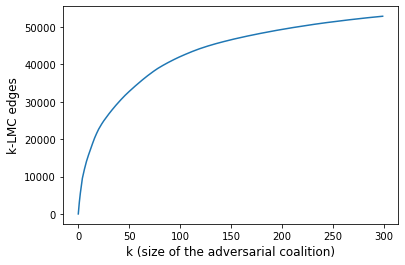

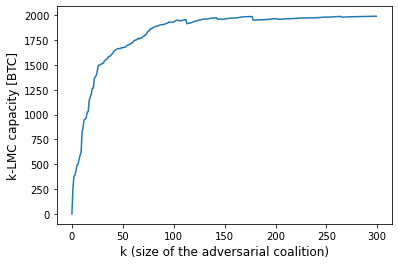

In [32]:
import matplotlib.pyplot as plt
import json
import math

OPT_capacity = 258711667453 # Optimal capacity of the max cut (weighted), as computed in Neo4j (without constraints on the size of the adversarial coalition)
OPT_edges = 62249 # Optimal number of edges in the max cut (unweighted), as computed in Neo4j (without constraints on the size of the adversarial coalition)

LWMC_MAX_CAPACITY = max(C_w) # Maximum capacity of the max-cut computed with LWMC (with k = n/2)
LMC_MAX_NUMBER_OF_EDGES = max(C)

print("LWMC:\n")

#print("max cut capacity = " + str(max(C_w)))
#print("max cut edges = " + str(max(edges_count_w)))

#weighted_output_json_array = []

for k in range(10, 301, 10): # 501
    print("k = " + str(k))

    print(f'capacity = {C_w[k]:d}')
    print(f'number of edges = {edges_count_w[k]:d}')

    print(f'capacity over OPT capacity = {C_w[k]:d} / {OPT_capacity:d} = {100*C_w[k]/OPT_capacity:2.2f}%')
    print(f'number of edges over OPT number of edges = {edges_count_w[k]:d} / {OPT_edges:d} = {100*edges_count_w[k]/OPT_edges:2.2f}%')

    print(f'capacity over MAX LWMC capacity = {C_w[k]:d} / {LWMC_MAX_CAPACITY:d} = {100*C_w[k]/LWMC_MAX_CAPACITY:2.2f}%')

    print("******************************************")
    #output = {}
    #output["k"] = k
    #output["edges"] = edges_count_w[k]
    #output["capacity"] = C_w[k] / (math.pow(10, 8))
    #weighted_output_json_array.append(output)

#with open('weighted-imbalanced-max-cut-output.json', 'w') as outfile:
    #json.dump(weighted_output_json_array, outfile)

#plt.plot(C_w[0:k])
plt.plot([x / (math.pow(10, 8))for x in C_w[0:k]])
plt.ylabel('k-LWMC capacity [BTC]', fontsize=12)
plt.xlabel('k (size of the adversarial coalition)', fontsize=12)
plt.show()

plt.plot(edges_count_w[0:k])
plt.ylabel('k-LWMC edges', fontsize=12)
plt.xlabel('k (size of the adversarial coalition)', fontsize=12)
plt.show()

print("LMC:\n")

for k in range(10, 301, 10): # 501
    print("k = " + str(k))

    print(f'capacity = {edges_capacity[k]:d}')
    print(f'number of edges = {C[k]:d}')

    print(f'capacity over OPT capacity = {edges_capacity[k]:d} / {OPT_capacity:d} = {100*edges_capacity[k]/OPT_capacity:2.2f}%')
    print(f'number of edges over OPT number of edges = {C[k]:d} / {OPT_edges:d} = {100*C[k]/OPT_edges:2.2f}%')

    print(f'number of edges over MAX LMC number of edges = {C[k]:d} / {LMC_MAX_NUMBER_OF_EDGES:d} = {100*C[k]/LMC_MAX_NUMBER_OF_EDGES:2.2f}%')

    print("******************************************")


    # print("k = " + str(k))

    # print(f'edges = {edges_count[k]:d} / {max(edges_count):d} = {100*edges_count[k]/max(edges_count):2.2f}%')
    # print(f'capacity = {edges_capacity[k]:d} / {max(C_w):d} = {100*C_w[k]/max(C_w):2.2f}%')

plt.plot(C[0:k])
plt.ylabel('k-LMC edges', fontsize=12)
plt.xlabel('k (size of the adversarial coalition)', fontsize=12)
plt.show()

#plt.plot(edges_capacity[0:k])
plt.plot([x / (math.pow(10, 8))for x in edges_capacity[0:k]])
plt.ylabel('k-LMC capacity [BTC]', fontsize=12)
plt.xlabel('k (size of the adversarial coalition)', fontsize=12)
plt.show()

